In [18]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_plot  import *
from sub_climatology  import *
from colormap_c2c    import *
from sub_regriding_adapt import *
from sub_fesom_data_netcdf4  import * 
from sub_fesom_paperplot import *

#___________________________________________________________________________________________________________________
# LOAD FESOM2.0 MESH
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['use_cavity'] = False
# inputarray['use_cavity'] = True
# set plot box for cyl projection (default: [-180,180,-90,90])
# inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'],inputarray['proj'] = [-180,180,-90,90], 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'
# inputarray['which_box'],inputarray['proj'] = [-70, 15,-90,-55], 'cyl'
# inputarray['which_box'],inputarray['proj'] = [-120, -60,-90,-65], 'cyl'
# inputarray['which_box'],inputarray['proj'] = [-180, 180,78,90], 'npstere'
# inputarray['which_box'],inputarray['proj'] = [-180, 180,-90,-60], 'spstere'
inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/core2_meanz/'
# inputarray['mesh_id'],inputarray['mesh_dir'] = 'mehmet','/work/ollie/pscholz/mesh_fesom2.0/mesh_mehmet_tss/'
# inputarray['mesh_alpha'],inputarray['mesh_beta'],inputarray['mesh_gamma'] = 0,0,0
# inputarray['mesh_id'],inputarray['mesh_dir'] = '72k_cavity','/work/ollie/pscholz/mesh_fesom2.0/cavity_72k/'

try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_nodearea()
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_nodearea()
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 --> ___FOUND COREv2 FESOM MESH --> will use it!___________________________


<IPython.core.display.Javascript object>


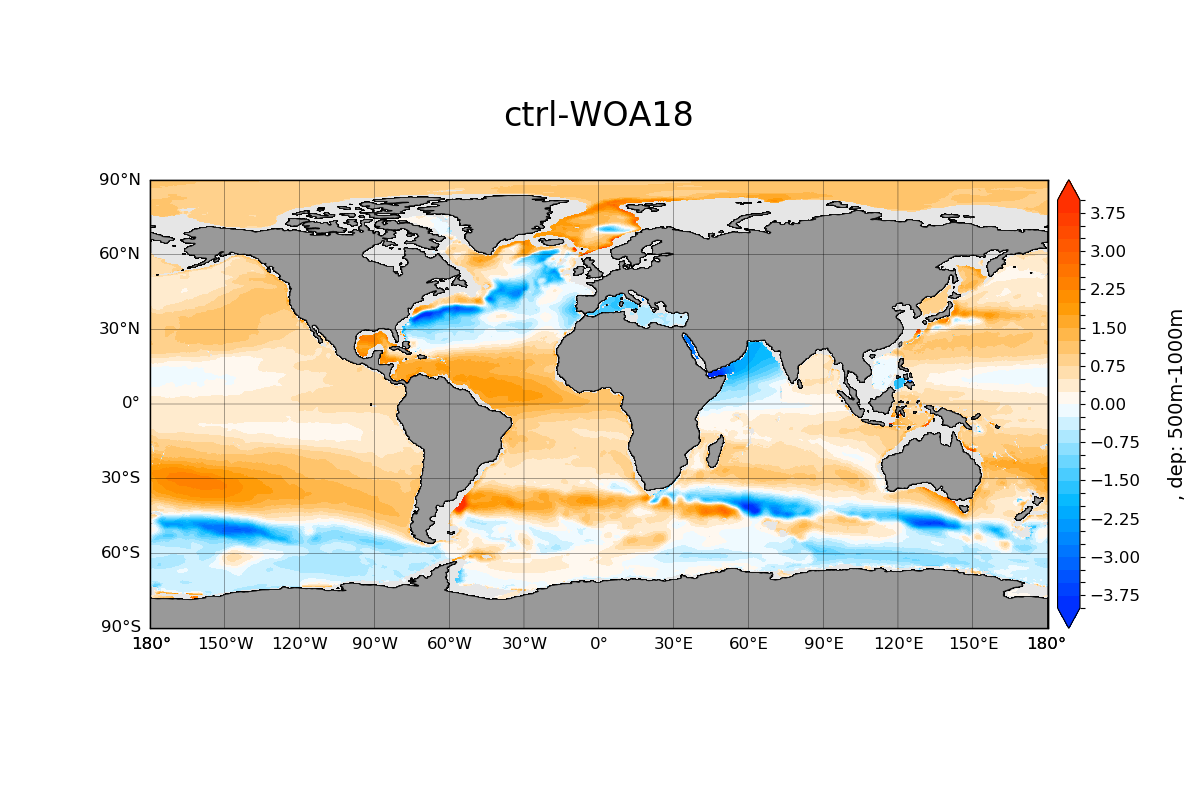

/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_climatology.py:242: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  )


[cmin,cmax,cref] = [-4.0, 4.0, 0.0]
clevel =  [-4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25
 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5   1.75
  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.  ]


/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_climatology.py:313: RuntimeWarning: invalid value encountered in less
  data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps
/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_climatology.py:314: RuntimeWarning: invalid value encountered in greater
  


In [20]:
which_woa = 'woa2018'

#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** SET INPUT PARAMETER ***                         |
#|                                                                             |
#+_____________________________________________________________________________+
# setup variable name, runid and data path
data 			= fesom_data(inputarray) # init fesom2.0 data object
data.descript,data.path = 'ctrl' ,'../results/new_linfs/new_fesom_kpp/3/'
data.var 		= 'temp'

#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
data.year		= [1998,2009]

# select month to average over
data.month		=  list(range(1,12+1))
#data.month		= [1,2,12]
#data.month		= [6,7,8]
#data.month		= [3]

# select linear interpolated depth layers to average over
#data.depth		= [0,10,20,30,40,50,75,100]
# data.depth		= np.arange(   0, 250+1,10)
#data.depth		= np.arange( 250, 500+1,20)
data.depth		= np.arange( 500,1000+1,50)
#data.depth		= np.arange(1000,2000+1,50)
#data.depth		= np.arange(2000,4000+1,50)

#+_____________________________________________________________________________+
#|                         *** LOAD CLIMATOLOGY ***                            |
#+_____________________________________________________________________________+
if which_woa=='woa2005': clim_descr, clim_path, clim_fname  = 'WOA05', '../view/woa2005/', 'woa2005TS.nc'
if which_woa=='woa2018': clim_descr, clim_path, clim_fname  = 'WOA18', '/work/ollie/pscholz/INIT_HYDRO/woa2018/', 'woa2018TS_0.25deg.nc'
clim  = clim_data(clim_path,clim_fname,data.var)
clim.descript = data.descript+'-'+clim_descr
clim.crange,clim.cmap, clim.cnumb      = data.crange,data.cmap, data.cnumb
clim.str_time, clim.str_dep            = data.str_time, data.str_dep
clim.sname, clim.lname, clim.unit      = data.sname, data.lname, data.unit
clim.proj, clim.proj_lon, clim.proj_lat= data.proj, data.proj_lon, data.proj_lat

#+_____________________________________________________________________________+
#|                         *** LOAD FESOM2.0 DATA ***                          |
#+_____________________________________________________________________________+
    
fesom_load_data_horiz_netcdf4(mesh,data,do_output=False)
dclim = clim_data_anom(mesh,clim,data,clim_descr)

if   dclim.var=='temp': dclim.crange = [-4.0,4.0,0] # [cmin, cmax, cref]
elif dclim.var=='salt': dclim.crange = [-1.0,1.0,0] # [cmin, cmax, cref]
dclim.cmap, dclim.cnumb = 'blue2red', 20
fig,ax,map,cbar=clim_plot_anom(mesh, dclim)
